[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/074_preceiver_intro/074_preceiver_intro.ipynb)

# PerceiverIO

En el post anterior vimos la arquitectura *Perceiver*, base del modelo más avanzado *PerceiverIO*, el cual aprenderemos a implementar en este post.

![](https://lh3.googleusercontent.com/355TNHvZGNS2yaYFD1yhlZt_JsyAQGCc8XMWf0bX0FhFK-O7HjJsBrnuOvazj3OfzBkTSZYGJ1wMHPJlYW21Fhhi-5bxYOgk9TqHMIEA0yEGmD9H5A=w1440-rw-v1)

A grandes rasgos, *PerceiverIO* es muy similar a *Perceiver*. Utiliza exactamente la misma arquitectura para la codificación y procesado de datos. La única diferencia es en la salida, ya que introduce un *decoder* que es capaz de generar *outputs* para diferentes tareas. Gracias a este desacople entre entradas/salidas y el procesado de características, la red neuronal es capaz de llevar a cabo multitud de tareas en vez de tener que recurrir a modelos específicos (CNNs, RNNs, ...) en función del tipo de datos y tarea que queramos llevar a cabo.

In [1]:
# https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
# https://github.com/esceptico/perceiver-io/blob/master/src/perceiver/attention.py

import math
import torch

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.n_embd = q_dim
        self.n_heads = n_heads
        assert self.n_embd % self.n_heads == 0
        # key, query, value projections
        self.key = torch.nn.Linear(kv_dim, self.n_embd)
        self.query = torch.nn.Linear(q_dim, self.n_embd)
        self.value = torch.nn.Linear(kv_dim, self.n_embd)
        # regularization
        self.attn_drop = torch.nn.Dropout(attn_pdrop)
        self.resid_drop = torch.nn.Dropout(resid_pdrop)
        # output projection
        self.proj = torch.nn.Linear(self.n_embd, q_dim)

    def forward(self, kv, q, mask = None): 
        B, M, C = kv.size()
        B, N, D = q.size()
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, M, hs)
        q = self.query(q).view(B, N, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, N, hs)
        v = self.value(kv).view(B, M, self.n_heads, D // self.n_heads).transpose(1, 2) # (B, nh, M, hs)
        # attention (B, nh, N, hs) x (B, nh, hs, M) -> (B, nh, N, M)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if mask is not None:
            att = att.masked_fill(self.mask[:,:,:N,:M] == 0, float('-inf')) 
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, N, M) x (B, nh, M, hs) -> (B, nh, N, hs)
        y = y.transpose(1, 2).contiguous().view(B, N, D) # re-assemble all head outputs side by side
        return self.resid_drop(self.proj(y)) # B, N, D

class Block(torch.nn.Module):
    def __init__(self, kv_dim, q_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.ln1_kv = torch.nn.LayerNorm(kv_dim)
        self.ln1_q = torch.nn.LayerNorm(q_dim)
        self.ln2 = torch.nn.LayerNorm(q_dim)
        self.attn = MultiHeadAttention(kv_dim, q_dim, n_heads, attn_pdrop, resid_pdrop)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(q_dim, 4 * q_dim),
            torch.nn.GELU(),
            torch.nn.Linear(4 * q_dim, q_dim),
            torch.nn.Dropout(resid_pdrop),
        )

    def forward(self, kv, q, mask=None):
        x = q + self.attn(self.ln1_kv(kv), self.ln1_q(q), mask)
        x = x + self.mlp(self.ln2(x))
        return x

class PerceiverEncoder(torch.nn.Module):
    # ejemplo sin recurrencia para clasificación
    def __init__(self, num_latents, latent_dim, input_dim, num_blocks, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        # se podrían separar los params en función de si es cross o self ...
        super().__init__()
        self.num_blocks = num_blocks
        self.latents = torch.nn.Parameter(torch.randn(num_latents, latent_dim))
        # encode
        self.cross_attn = Block(
            kv_dim=input_dim, 
            q_dim=latent_dim, 
            n_heads=n_heads, 
            attn_pdrop=attn_pdrop, 
            resid_pdrop=resid_pdrop
        )
        # process
        self.self_attention_blocks = torch.nn.ModuleList([
            Block( # se podrían hacer bloques diferenciados para en el forward pasar solo x
                kv_dim=latent_dim,
                q_dim=latent_dim,
                n_heads=n_heads, 
                attn_pdrop=attn_pdrop, 
                resid_pdrop=resid_pdrop
            ) for _ in range(num_blocks)
        ])

    def forward(self, x, mask = None):
        B = x.size(0)
        if mask is not None:
            mask = mask[None, None, :, :] # esto no se si está bien :S
        x = self.cross_attn(
            kv=x,
            q=self.latents.repeat(B, 1, 1),
            mask=mask
        )
        for _ in range(self.num_blocks):
            for self_attn_layer in self.self_attention_blocks:
                x = self_attn_layer(x, x)
        return x

Para este primer ejemplo vamos a implementar un *decoder* para clasificación de imágenes. Este *decoder* recibirá la salida del *encoder*, que ya implementamos en el post anterior, y que usaremos como *keys* y *values*. En cuanto a las *query*, usaremos un tensor con las dimensiones a las que queramos proyectar las salidas del *encoder*, en nuestro caso al número de clases a las cuales queramos hacer la clasificación. De la misma manera que el modelo aprenderá la mejor representación para las *query* a la entrada, lo mismo hacemos a la salida.

In [2]:
# https://github.com/esceptico/perceiver-io/blob/master/src/perceiver/decoders.py

class ClassificationDecoder(torch.nn.Module):
    def __init__(self, num_classes, latent_dim, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        self.task_ids = torch.nn.Parameter(torch.randn(1, num_classes))
        self.decoder = Block( 
            kv_dim=latent_dim,
            q_dim=num_classes,
            n_heads=n_heads, 
            attn_pdrop=attn_pdrop, 
            resid_pdrop=resid_pdrop
        )

    def forward(self, latents):
        b = latents.size(0)
        logits = self.decoder(
            kv=latents,
            q=self.task_ids.repeat(b, 1, 1)
        )
        return logits.squeeze(1)

In [3]:
decoder = ClassificationDecoder(10, 512)

decoder

ClassificationDecoder(
  (decoder): Block(
    (ln1_kv): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (ln1_q): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
    (attn): MultiHeadAttention(
      (key): Linear(in_features=512, out_features=10, bias=True)
      (query): Linear(in_features=10, out_features=10, bias=True)
      (value): Linear(in_features=512, out_features=10, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (resid_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=10, out_features=10, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): GELU()
      (2): Linear(in_features=40, out_features=10, bias=True)
      (3): Dropout(p=0.0, inplace=False)
    )
  )
)

In [4]:
output = decoder(torch.randn(32, 128, 512))

output.shape

torch.Size([32, 10])

Como puedes ver, podemos adaptar el *decoder* de manera muy sencilla para generar *outputs* de la dimensión que queramos, haciendo del *PerceiverIO* una arquitectura muy flexible. Podríamos tener diversos *decoders* para generar múltiples outputs o incluso entrenar un solo modelo con un solo *decoder* pero diferentes *query* para diferentes tareas (*multi-tasking*). Este hecho, junto a la flexibilidad a la hora de aceptar diferentes tipos de inputs que ya hereda del *Perciever* convierte a este modelo en uno de los más flexibles a día de hoy.

## Clasificación de imágenes

Vamos a ver el mismo ejemplo que vimos en el post anterior: clasificación de imágenes con el dataset CIFAR10. Esta vez, con el nuevo modelo.

In [5]:
from einops import rearrange, repeat
from math import pi, log

class FourierEncoder(torch.nn.Module):
    def __init__(self, max_freq, num_freq_bands, freq_base=2):
        super().__init__()
        self.max_freq = max_freq
        self.num_freq_bands = num_freq_bands
        self.freq_base = freq_base

    def fourier_encode(self, x):
        x = x.unsqueeze(-1)
        device, dtype, orig_x = x.device, x.dtype, x
        scales = torch.logspace(0., log(self.max_freq / 2) / log(self.freq_base), self.num_freq_bands, base = self.freq_base, device = device, dtype = dtype)
        scales = scales[(*((None,) * (len(x.shape) - 1)), ...)]
        x = x * scales * pi
        x = torch.cat([x.sin(), x.cos()], dim=-1)
        x = torch.cat((x, orig_x), dim = -1)
        return x

    def forward(self, x):
         # fourier encoding
        b, *axis, _, device = *x.shape, x.device
        axis_pos = list(map(lambda size: torch.linspace(-1., 1., steps = size, device = device), axis))
        pos = torch.stack(torch.meshgrid(*axis_pos), dim = -1)
        enc_pos = self.fourier_encode(pos)
        enc_pos = rearrange(enc_pos, '... n d -> ... (n d)')
        enc_pos = repeat(enc_pos, '... -> b ...', b = b)
        x = torch.cat((x, enc_pos), dim = -1)
        x = rearrange(x, 'b ... d -> b (...) d')
        return x

In [6]:
class PerceiverIO(torch.nn.Module):
    def __init__(self, num_classes, max_freq ,num_freq_bands, num_latents, latent_dim, input_dim, num_blocks, freq_base = 2, n_heads=1, attn_pdrop=0., resid_pdrop=0.):
        super().__init__()
        fourier_channels = (2 * ((num_freq_bands * 2) + 1))
        input_dim += fourier_channels
        self.fourier_encoder = FourierEncoder(
            max_freq=max_freq,
            num_freq_bands=num_freq_bands,
            freq_base=freq_base
        )
        self.encoder = PerceiverEncoder(
            num_latents=num_latents, 
            latent_dim=latent_dim, 
            input_dim=input_dim,
            num_blocks=num_blocks,
            n_heads=n_heads, 
            attn_pdrop=attn_pdrop, 
            resid_pdrop=resid_pdrop
        )
        self.decoder = ClassificationDecoder(
            num_classes=num_classes,
            latent_dim=latent_dim,
            n_heads=n_heads,
            attn_pdrop=attn_pdrop,
            resid_pdrop=resid_pdrop
        )

    def forward(self, x, mask = None):
        x = self.fourier_encoder(x)
        if mask is not None:
            mask = mask[None, None, :, :] # esto no se si está bien :S
        x = self.encoder(x, mask)
        return self.decoder(x)

In [7]:
perceiver = PerceiverIO(num_classes=10, max_freq=10, num_freq_bands=6, num_latents=256, latent_dim=512, input_dim=3, num_blocks=2)

output = perceiver(torch.randn(32, 32, 32, 3))

output.shape

torch.Size([32, 10])

In [8]:
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).float(), torch.tensor(self.labels[ix]).long()

In [9]:
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}

batch_size = 64
num_workers = 0

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

Files already downloaded and verified
Files already downloaded and verified


(torch.Size([64, 32, 32, 3]), torch.Size([64]))

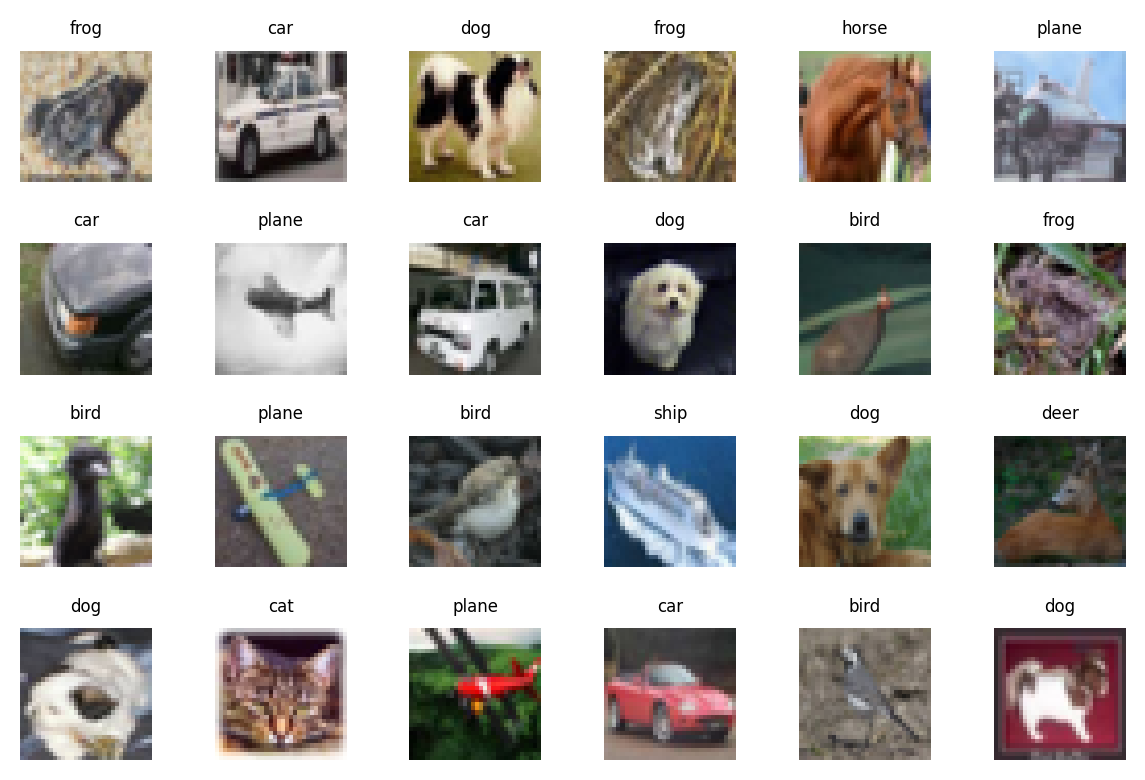

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        ax.set_title(ds['train'].classes[labels[ix].item()], fontsize=6)
        ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
from tqdm import tqdm
import torch.nn.functional as F

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cuda", use_amp=True, overfit=False):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        # como cambiar el shuffle a False si overfit ?
        for batch in bar:
            optimizer.zero_grad()            
            with torch.cuda.amp.autocast(enabled=use_amp):
                loss, acc = step(model, batch, device)
            scaler.scale(loss).backward()
            # gradient clipping
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            scaler.step(optimizer)
            scaler.update()
            l.append(loss.item())
            a.append(acc)
            if overfit: 
                break
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        # eval
        model.eval()
        l, a = [], []
        if overfit:
            bar = tqdm(dl['train'])
        else:
            bar = tqdm(dl['test'])
        with torch.inference_mode():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                if overfit: 
                    break
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        if not overfit:
            # log
            log = f'Epoch {e}/{epochs}'
            for k, v in hist.items():
                log += f' {k} {v[-1]:.4f}'
            print(log)
    return hist

In [12]:
import pandas as pd

def plot_hist(hist):
    fig = plt.figure(figsize=(10, 3), dpi=100)
    df = pd.DataFrame(hist)
    ax = plt.subplot(1, 2, 1)
    df[['loss', 'test_loss']].plot(ax=ax)
    ax.grid(True)
    ax = plt.subplot(1, 2, 2)
    df[['acc', 'test_acc']].plot(ax=ax)
    ax.grid(True)
    plt.show()

In [13]:
model = PerceiverIO(num_classes=10, max_freq=5, num_freq_bands=3, num_latents=32, latent_dim=32, input_dim=3, num_blocks=3)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=512, shuffle=True, num_workers=0),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=512, shuffle=False, num_workers=0)
}

In [14]:
hist = train(model, dl, optimizer, epochs=100, overfit=False)

testing... loss 2.2934 acc 0.1033: 100%|██████████| 20/20 [00:00<00:00, 28.41it/s]


Epoch 1/100 loss 2.3811 acc 0.1098 test_loss 2.2934 test_acc 0.1033


testing... loss 2.0771 acc 0.2023: 100%|██████████| 20/20 [00:00<00:00, 27.82it/s]


Epoch 2/100 loss 2.1549 acc 0.1736 test_loss 2.0771 test_acc 0.2023


testing... loss 2.0497 acc 0.2122: 100%|██████████| 20/20 [00:00<00:00, 27.66it/s]


Epoch 3/100 loss 2.0760 acc 0.1995 test_loss 2.0497 test_acc 0.2122


testing... loss 2.0228 acc 0.2292: 100%|██████████| 20/20 [00:00<00:00, 27.83it/s]


Epoch 4/100 loss 2.0565 acc 0.2119 test_loss 2.0228 test_acc 0.2292


testing... loss 1.9282 acc 0.2889: 100%|██████████| 20/20 [00:00<00:00, 28.44it/s]


Epoch 5/100 loss 1.9831 acc 0.2552 test_loss 1.9282 test_acc 0.2889


testing... loss 1.8484 acc 0.3219: 100%|██████████| 20/20 [00:00<00:00, 27.84it/s]


Epoch 6/100 loss 1.8985 acc 0.2953 test_loss 1.8484 test_acc 0.3219


testing... loss 1.7425 acc 0.3582: 100%|██████████| 20/20 [00:00<00:00, 28.16it/s]


Epoch 7/100 loss 1.8108 acc 0.3353 test_loss 1.7425 test_acc 0.3582


testing... loss 1.6939 acc 0.3838: 100%|██████████| 20/20 [00:00<00:00, 28.05it/s]


Epoch 8/100 loss 1.7339 acc 0.3666 test_loss 1.6939 test_acc 0.3838


testing... loss 1.6884 acc 0.3777: 100%|██████████| 20/20 [00:00<00:00, 27.89it/s]


Epoch 9/100 loss 1.6952 acc 0.3814 test_loss 1.6884 test_acc 0.3777


testing... loss 1.6208 acc 0.4090: 100%|██████████| 20/20 [00:00<00:00, 27.38it/s]


Epoch 10/100 loss 1.6638 acc 0.3961 test_loss 1.6208 test_acc 0.4090


testing... loss 1.5948 acc 0.4238: 100%|██████████| 20/20 [00:00<00:00, 27.68it/s]


Epoch 11/100 loss 1.6367 acc 0.4061 test_loss 1.5948 test_acc 0.4238


testing... loss 1.5819 acc 0.4251: 100%|██████████| 20/20 [00:00<00:00, 28.28it/s]


Epoch 12/100 loss 1.6089 acc 0.4159 test_loss 1.5819 test_acc 0.4251


testing... loss 1.5637 acc 0.4369: 100%|██████████| 20/20 [00:00<00:00, 27.06it/s]


Epoch 13/100 loss 1.5846 acc 0.4255 test_loss 1.5637 test_acc 0.4369


testing... loss 1.5686 acc 0.4363: 100%|██████████| 20/20 [00:00<00:00, 21.76it/s]


Epoch 14/100 loss 1.5804 acc 0.4268 test_loss 1.5686 test_acc 0.4363


testing... loss 1.5497 acc 0.4373: 100%|██████████| 20/20 [00:00<00:00, 27.93it/s]


Epoch 15/100 loss 1.5546 acc 0.4352 test_loss 1.5497 test_acc 0.4373


testing... loss 1.5105 acc 0.4556: 100%|██████████| 20/20 [00:00<00:00, 49.02it/s]


Epoch 16/100 loss 1.5392 acc 0.4435 test_loss 1.5105 test_acc 0.4556


testing... loss 1.5199 acc 0.4486: 100%|██████████| 20/20 [00:00<00:00, 48.83it/s]


Epoch 17/100 loss 1.5258 acc 0.4483 test_loss 1.5199 test_acc 0.4486


testing... loss 1.5123 acc 0.4554: 100%|██████████| 20/20 [00:00<00:00, 29.02it/s]


Epoch 18/100 loss 1.5041 acc 0.4557 test_loss 1.5123 test_acc 0.4554


testing... loss 1.4797 acc 0.4690: 100%|██████████| 20/20 [00:00<00:00, 48.90it/s]


Epoch 19/100 loss 1.4977 acc 0.4575 test_loss 1.4797 test_acc 0.4690


testing... loss 1.4653 acc 0.4736: 100%|██████████| 20/20 [00:00<00:00, 49.14it/s]


Epoch 20/100 loss 1.4832 acc 0.4642 test_loss 1.4653 test_acc 0.4736


testing... loss 1.4632 acc 0.4715: 100%|██████████| 20/20 [00:00<00:00, 47.73it/s]


Epoch 21/100 loss 1.4663 acc 0.4728 test_loss 1.4632 test_acc 0.4715


testing... loss 1.4941 acc 0.4616: 100%|██████████| 20/20 [00:00<00:00, 47.17it/s]


Epoch 22/100 loss 1.4546 acc 0.4767 test_loss 1.4941 test_acc 0.4616


testing... loss 1.4661 acc 0.4732: 100%|██████████| 20/20 [00:00<00:00, 27.58it/s]


Epoch 23/100 loss 1.4402 acc 0.4794 test_loss 1.4661 test_acc 0.4732


testing... loss 1.4415 acc 0.4808: 100%|██████████| 20/20 [00:00<00:00, 26.70it/s]


Epoch 24/100 loss 1.4262 acc 0.4856 test_loss 1.4415 test_acc 0.4808


testing... loss 1.4238 acc 0.4894: 100%|██████████| 20/20 [00:00<00:00, 21.64it/s]


Epoch 25/100 loss 1.4143 acc 0.4902 test_loss 1.4238 test_acc 0.4894


testing... loss 1.4064 acc 0.4957: 100%|██████████| 20/20 [00:00<00:00, 26.49it/s]


Epoch 26/100 loss 1.4003 acc 0.4948 test_loss 1.4064 test_acc 0.4957


testing... loss 1.3969 acc 0.4983: 100%|██████████| 20/20 [00:00<00:00, 27.15it/s]


Epoch 27/100 loss 1.4040 acc 0.4928 test_loss 1.3969 test_acc 0.4983


testing... loss 1.4191 acc 0.4874: 100%|██████████| 20/20 [00:00<00:00, 27.13it/s]


Epoch 28/100 loss 1.3828 acc 0.5019 test_loss 1.4191 test_acc 0.4874


testing... loss 1.3913 acc 0.4961: 100%|██████████| 20/20 [00:00<00:00, 27.32it/s]


Epoch 29/100 loss 1.3719 acc 0.5053 test_loss 1.3913 test_acc 0.4961


testing... loss 1.3983 acc 0.4983: 100%|██████████| 20/20 [00:00<00:00, 27.51it/s]


Epoch 30/100 loss 1.3585 acc 0.5102 test_loss 1.3983 test_acc 0.4983


testing... loss 1.3798 acc 0.5019: 100%|██████████| 20/20 [00:00<00:00, 27.03it/s]


Epoch 31/100 loss 1.3511 acc 0.5136 test_loss 1.3798 test_acc 0.5019


testing... loss 1.3807 acc 0.5007: 100%|██████████| 20/20 [00:00<00:00, 27.43it/s]


Epoch 32/100 loss 1.3487 acc 0.5164 test_loss 1.3807 test_acc 0.5007


testing... loss 1.3620 acc 0.5118: 100%|██████████| 20/20 [00:00<00:00, 26.49it/s]


Epoch 33/100 loss 1.3375 acc 0.5169 test_loss 1.3620 test_acc 0.5118


testing... loss 1.3572 acc 0.5152: 100%|██████████| 20/20 [00:00<00:00, 27.32it/s]


Epoch 34/100 loss 1.3291 acc 0.5211 test_loss 1.3572 test_acc 0.5152


testing... loss 1.3868 acc 0.5014: 100%|██████████| 20/20 [00:00<00:00, 27.06it/s]


Epoch 35/100 loss 1.3181 acc 0.5249 test_loss 1.3868 test_acc 0.5014


testing... loss 1.3479 acc 0.5183: 100%|██████████| 20/20 [00:00<00:00, 21.57it/s]


Epoch 36/100 loss 1.3129 acc 0.5274 test_loss 1.3479 test_acc 0.5183


testing... loss 1.3514 acc 0.5137: 100%|██████████| 20/20 [00:00<00:00, 27.56it/s]


Epoch 37/100 loss 1.3018 acc 0.5316 test_loss 1.3514 test_acc 0.5137


testing... loss 1.3564 acc 0.5182: 100%|██████████| 20/20 [00:00<00:00, 26.95it/s]


Epoch 38/100 loss 1.2942 acc 0.5358 test_loss 1.3564 test_acc 0.5182


testing... loss 1.3581 acc 0.5121: 100%|██████████| 20/20 [00:00<00:00, 27.25it/s]


Epoch 39/100 loss 1.2867 acc 0.5367 test_loss 1.3581 test_acc 0.5121


testing... loss 1.3386 acc 0.5207: 100%|██████████| 20/20 [00:00<00:00, 26.88it/s]


Epoch 40/100 loss 1.2768 acc 0.5437 test_loss 1.3386 test_acc 0.5207


testing... loss 1.3366 acc 0.5237: 100%|██████████| 20/20 [00:00<00:00, 27.36it/s]


Epoch 41/100 loss 1.2806 acc 0.5404 test_loss 1.3366 test_acc 0.5237


testing... loss 1.3217 acc 0.5274: 100%|██████████| 20/20 [00:00<00:00, 27.40it/s]


Epoch 42/100 loss 1.2720 acc 0.5437 test_loss 1.3217 test_acc 0.5274


testing... loss 1.3133 acc 0.5289: 100%|██████████| 20/20 [00:00<00:00, 26.84it/s]


Epoch 43/100 loss 1.2579 acc 0.5506 test_loss 1.3133 test_acc 0.5289


testing... loss 1.3132 acc 0.5326: 100%|██████████| 20/20 [00:00<00:00, 27.25it/s]


Epoch 44/100 loss 1.2551 acc 0.5496 test_loss 1.3132 test_acc 0.5326


testing... loss 1.3066 acc 0.5414: 100%|██████████| 20/20 [00:00<00:00, 27.03it/s]


Epoch 45/100 loss 1.2487 acc 0.5510 test_loss 1.3066 test_acc 0.5414


testing... loss 1.3054 acc 0.5371: 100%|██████████| 20/20 [00:00<00:00, 27.14it/s]


Epoch 46/100 loss 1.2312 acc 0.5579 test_loss 1.3054 test_acc 0.5371


testing... loss 1.3089 acc 0.5368: 100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


Epoch 47/100 loss 1.2329 acc 0.5573 test_loss 1.3089 test_acc 0.5368


testing... loss 1.3138 acc 0.5314: 100%|██████████| 20/20 [00:00<00:00, 27.36it/s]


Epoch 48/100 loss 1.2341 acc 0.5570 test_loss 1.3138 test_acc 0.5314


testing... loss 1.3217 acc 0.5302: 100%|██████████| 20/20 [00:00<00:00, 26.70it/s]


Epoch 49/100 loss 1.2207 acc 0.5621 test_loss 1.3217 test_acc 0.5302


testing... loss 1.2936 acc 0.5425: 100%|██████████| 20/20 [00:00<00:00, 27.27it/s]


Epoch 50/100 loss 1.2147 acc 0.5645 test_loss 1.2936 test_acc 0.5425


testing... loss 1.3508 acc 0.5247: 100%|██████████| 20/20 [00:00<00:00, 26.77it/s]


Epoch 51/100 loss 1.2139 acc 0.5635 test_loss 1.3508 test_acc 0.5247


testing... loss 1.2985 acc 0.5388: 100%|██████████| 20/20 [00:00<00:00, 27.23it/s]


Epoch 52/100 loss 1.1993 acc 0.5706 test_loss 1.2985 test_acc 0.5388


testing... loss 1.2966 acc 0.5421: 100%|██████████| 20/20 [00:00<00:00, 27.03it/s]


Epoch 53/100 loss 1.1939 acc 0.5718 test_loss 1.2966 test_acc 0.5421


testing... loss 1.2901 acc 0.5441: 100%|██████████| 20/20 [00:00<00:00, 26.63it/s]


Epoch 54/100 loss 1.1905 acc 0.5756 test_loss 1.2901 test_acc 0.5441


testing... loss 1.2890 acc 0.5414: 100%|██████████| 20/20 [00:00<00:00, 27.03it/s]


Epoch 55/100 loss 1.1812 acc 0.5776 test_loss 1.2890 test_acc 0.5414


testing... loss 1.2939 acc 0.5419: 100%|██████████| 20/20 [00:00<00:00, 27.06it/s]


Epoch 56/100 loss 1.1738 acc 0.5789 test_loss 1.2939 test_acc 0.5419


testing... loss 1.3074 acc 0.5404: 100%|██████████| 20/20 [00:00<00:00, 27.29it/s]


Epoch 57/100 loss 1.1721 acc 0.5807 test_loss 1.3074 test_acc 0.5404


testing... loss 1.2926 acc 0.5383: 100%|██████████| 20/20 [00:00<00:00, 21.39it/s]


Epoch 58/100 loss 1.1667 acc 0.5827 test_loss 1.2926 test_acc 0.5383


testing... loss 1.2905 acc 0.5472: 100%|██████████| 20/20 [00:00<00:00, 27.51it/s]


Epoch 59/100 loss 1.1564 acc 0.5873 test_loss 1.2905 test_acc 0.5472


testing... loss 1.2844 acc 0.5470: 100%|██████████| 20/20 [00:00<00:00, 27.40it/s]


Epoch 60/100 loss 1.1577 acc 0.5850 test_loss 1.2844 test_acc 0.5470


testing... loss 1.2923 acc 0.5463: 100%|██████████| 20/20 [00:00<00:00, 27.51it/s]


Epoch 61/100 loss 1.1446 acc 0.5929 test_loss 1.2923 test_acc 0.5463


testing... loss 1.2844 acc 0.5483: 100%|██████████| 20/20 [00:00<00:00, 27.38it/s]


Epoch 62/100 loss 1.1379 acc 0.5932 test_loss 1.2844 test_acc 0.5483


testing... loss 1.3125 acc 0.5340: 100%|██████████| 20/20 [00:00<00:00, 28.07it/s]


Epoch 63/100 loss 1.1335 acc 0.5937 test_loss 1.3125 test_acc 0.5340


testing... loss 1.2735 acc 0.5502: 100%|██████████| 20/20 [00:00<00:00, 27.86it/s]


Epoch 64/100 loss 1.1259 acc 0.5966 test_loss 1.2735 test_acc 0.5502


testing... loss 1.2663 acc 0.5540: 100%|██████████| 20/20 [00:00<00:00, 27.17it/s]


Epoch 65/100 loss 1.1239 acc 0.5968 test_loss 1.2663 test_acc 0.5540


testing... loss 1.2773 acc 0.5526: 100%|██████████| 20/20 [00:00<00:00, 27.21it/s]


Epoch 66/100 loss 1.1187 acc 0.5990 test_loss 1.2773 test_acc 0.5526


testing... loss 1.2869 acc 0.5465: 100%|██████████| 20/20 [00:00<00:00, 27.01it/s]


Epoch 67/100 loss 1.1053 acc 0.6047 test_loss 1.2869 test_acc 0.5465


testing... loss 1.2920 acc 0.5519: 100%|██████████| 20/20 [00:00<00:00, 26.83it/s]


Epoch 68/100 loss 1.1002 acc 0.6061 test_loss 1.2920 test_acc 0.5519


testing... loss 1.2981 acc 0.5455: 100%|██████████| 20/20 [00:00<00:00, 21.66it/s]


Epoch 69/100 loss 1.1010 acc 0.6073 test_loss 1.2981 test_acc 0.5455


testing... loss 1.2799 acc 0.5518: 100%|██████████| 20/20 [00:00<00:00, 28.82it/s]


Epoch 70/100 loss 1.0912 acc 0.6102 test_loss 1.2799 test_acc 0.5518


testing... loss 1.2719 acc 0.5546: 100%|██████████| 20/20 [00:00<00:00, 28.21it/s]


Epoch 71/100 loss 1.0833 acc 0.6130 test_loss 1.2719 test_acc 0.5546


testing... loss 1.3165 acc 0.5436: 100%|██████████| 20/20 [00:00<00:00, 28.29it/s]


Epoch 72/100 loss 1.0823 acc 0.6157 test_loss 1.3165 test_acc 0.5436


testing... loss 1.2951 acc 0.5464: 100%|██████████| 20/20 [00:00<00:00, 28.05it/s]


Epoch 73/100 loss 1.0824 acc 0.6128 test_loss 1.2951 test_acc 0.5464


testing... loss 1.3068 acc 0.5453: 100%|██████████| 20/20 [00:00<00:00, 27.74it/s]


Epoch 74/100 loss 1.0667 acc 0.6210 test_loss 1.3068 test_acc 0.5453


testing... loss 1.3002 acc 0.5484: 100%|██████████| 20/20 [00:00<00:00, 27.86it/s]


Epoch 75/100 loss 1.0641 acc 0.6188 test_loss 1.3002 test_acc 0.5484


testing... loss 1.2935 acc 0.5546: 100%|██████████| 20/20 [00:00<00:00, 27.36it/s]


Epoch 76/100 loss 1.0630 acc 0.6232 test_loss 1.2935 test_acc 0.5546


testing... loss 1.2867 acc 0.5562: 100%|██████████| 20/20 [00:00<00:00, 28.43it/s]


Epoch 77/100 loss 1.0482 acc 0.6276 test_loss 1.2867 test_acc 0.5562


testing... loss 1.2929 acc 0.5536: 100%|██████████| 20/20 [00:00<00:00, 27.78it/s]


Epoch 78/100 loss 1.0467 acc 0.6267 test_loss 1.2929 test_acc 0.5536


testing... loss 1.3330 acc 0.5456: 100%|██████████| 20/20 [00:00<00:00, 28.29it/s]


Epoch 79/100 loss 1.0374 acc 0.6313 test_loss 1.3330 test_acc 0.5456


testing... loss 1.3046 acc 0.5464: 100%|██████████| 20/20 [00:00<00:00, 21.81it/s]


Epoch 80/100 loss 1.0405 acc 0.6308 test_loss 1.3046 test_acc 0.5464


testing... loss 1.3136 acc 0.5453: 100%|██████████| 20/20 [00:00<00:00, 28.13it/s]


Epoch 81/100 loss 1.0349 acc 0.6301 test_loss 1.3136 test_acc 0.5453


testing... loss 1.2996 acc 0.5536: 100%|██████████| 20/20 [00:00<00:00, 27.86it/s]


Epoch 82/100 loss 1.0241 acc 0.6348 test_loss 1.2996 test_acc 0.5536


testing... loss 1.3090 acc 0.5493: 100%|██████████| 20/20 [00:00<00:00, 27.86it/s]


Epoch 83/100 loss 1.0228 acc 0.6339 test_loss 1.3090 test_acc 0.5493


testing... loss 1.3071 acc 0.5472: 100%|██████████| 20/20 [00:00<00:00, 27.38it/s]


Epoch 84/100 loss 1.0175 acc 0.6372 test_loss 1.3071 test_acc 0.5472


testing... loss 1.3073 acc 0.5563: 100%|██████████| 20/20 [00:00<00:00, 27.62it/s]


Epoch 85/100 loss 1.0095 acc 0.6403 test_loss 1.3073 test_acc 0.5563


testing... loss 1.3254 acc 0.5465: 100%|██████████| 20/20 [00:00<00:00, 28.13it/s]


Epoch 86/100 loss 1.0029 acc 0.6432 test_loss 1.3254 test_acc 0.5465


testing... loss 1.3072 acc 0.5484: 100%|██████████| 20/20 [00:00<00:00, 26.90it/s]


Epoch 87/100 loss 1.0009 acc 0.6427 test_loss 1.3072 test_acc 0.5484


testing... loss 1.3334 acc 0.5446: 100%|██████████| 20/20 [00:00<00:00, 27.85it/s]


Epoch 88/100 loss 0.9927 acc 0.6465 test_loss 1.3334 test_acc 0.5446


testing... loss 1.3375 acc 0.5472: 100%|██████████| 20/20 [00:00<00:00, 27.55it/s]


Epoch 89/100 loss 0.9832 acc 0.6488 test_loss 1.3375 test_acc 0.5472


testing... loss 1.3220 acc 0.5524: 100%|██████████| 20/20 [00:00<00:00, 27.62it/s]


Epoch 90/100 loss 0.9793 acc 0.6507 test_loss 1.3220 test_acc 0.5524


testing... loss 1.3379 acc 0.5475: 100%|██████████| 20/20 [00:00<00:00, 22.03it/s]


Epoch 91/100 loss 0.9758 acc 0.6513 test_loss 1.3379 test_acc 0.5475


testing... loss 1.3106 acc 0.5526: 100%|██████████| 20/20 [00:00<00:00, 28.09it/s]


Epoch 92/100 loss 0.9740 acc 0.6535 test_loss 1.3106 test_acc 0.5526


testing... loss 1.3296 acc 0.5500: 100%|██████████| 20/20 [00:00<00:00, 28.11it/s]


Epoch 93/100 loss 0.9675 acc 0.6562 test_loss 1.3296 test_acc 0.5500


testing... loss 1.3450 acc 0.5471: 100%|██████████| 20/20 [00:00<00:00, 27.86it/s]


Epoch 94/100 loss 0.9673 acc 0.6550 test_loss 1.3450 test_acc 0.5471


testing... loss 1.3583 acc 0.5475: 100%|██████████| 20/20 [00:00<00:00, 28.09it/s]


Epoch 95/100 loss 0.9593 acc 0.6560 test_loss 1.3583 test_acc 0.5475


testing... loss 1.3435 acc 0.5424: 100%|██████████| 20/20 [00:00<00:00, 28.87it/s]


Epoch 96/100 loss 0.9498 acc 0.6624 test_loss 1.3435 test_acc 0.5424


testing... loss 1.3752 acc 0.5370: 100%|██████████| 20/20 [00:00<00:00, 29.13it/s]


Epoch 97/100 loss 0.9456 acc 0.6621 test_loss 1.3752 test_acc 0.5370


testing... loss 1.3342 acc 0.5505: 100%|██████████| 20/20 [00:00<00:00, 29.00it/s]


Epoch 98/100 loss 0.9377 acc 0.6690 test_loss 1.3342 test_acc 0.5505


testing... loss 1.3591 acc 0.5505: 100%|██████████| 20/20 [00:00<00:00, 28.99it/s]


Epoch 99/100 loss 0.9311 acc 0.6694 test_loss 1.3591 test_acc 0.5505


testing... loss 1.3593 acc 0.5402: 100%|██████████| 20/20 [00:00<00:00, 30.00it/s]

Epoch 100/100 loss 0.9387 acc 0.6657 test_loss 1.3593 test_acc 0.5402


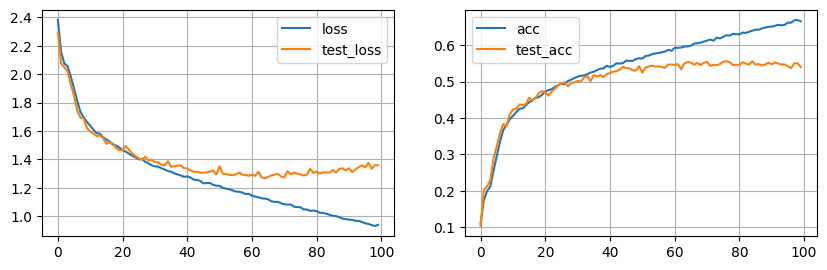

In [15]:
plot_hist(hist)

Tras 100 epochs nuestro modelo empieza a mostras síntomas de *overffiting*, podríamos pensar en activar el *dropout* del modelo, usar *data augmentation*, y otras técnicas de regularización.

In [18]:
imgs, labels = next(iter(dl['train']))

model.eval()
with torch.inference_mode():
    logits = model(imgs.cuda())
    preds = torch.argmax(logits, axis=1).cpu()

preds.shape

torch.Size([512])

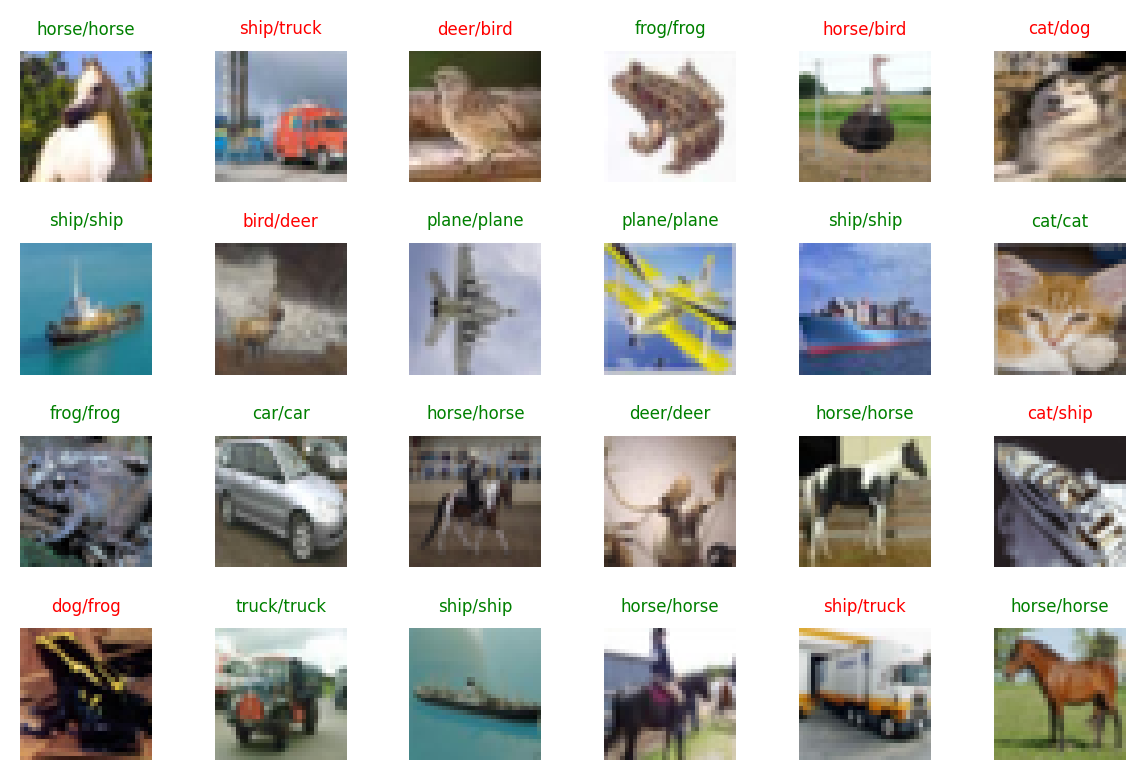

In [19]:
fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img)
        gt = ds['test'].classes[labels[ix].item()]
        pr = ds['test'].classes[preds[ix].item()]
        ax.set_title(f'{pr}/{gt}', fontsize=6, color='green' if pr == gt else 'red')
        ax.axis('off')
plt.tight_layout()
plt.show()

## Resumen

En este post hemos implementado nuestro primer modelo basado en la arquitectura *PercieverIO*. Para ello, hemos reutilizado el código implementado en el post anterior para el *Perceiver* y añadido la parte del *decoder*, capaz de generar *outputs* de dimensiones determinadas que podemos controlar. De esta manera, nuestro modelo desacopla totalmente las entradas/salidas de la parte de extracción y procesado de características convirtiendo al *PerceiverIO* en una red neuronal muy flexible capaz de trabajar con imágenes, texto, audio, video e incluso combinaciones de los mismos a la vez que puede usarse para diferentes tareas como la clasificación, generación de texto, detección de objetos en imágenes, etc. En los siguientes posts exploraremos más en detalle estas características.

## Recursos

- [Paper](https://arxiv.org/pdf/2107.14795.pdf)
- [Blog](https://deepmind.com/blog/article/building-architectures-that-can-handle-the-worlds-data) DeepMind.
- Videos:
    1. [Gaurav Chauhan](https://www.youtube.com/watch?v=AS1Sh-KuNzs&t=163s)
    2. [The AI Epiphany](https://www.youtube.com/watch?v=WJWBq4NZfvY&feature=youtu.be)
- Código:
    1. Implementación original de [DeepMind](https://github.com/deepmind/deepmind-research/tree/master/perceiver) (JAX)
    2. Pytorch: [lucidrains](https://github.com/lucidrains/perceiver-pytorch), [esceptico](https://github.com/esceptico/perceiver-io)